# Customer Lifetime Value

In [2]:
!pip install plyfile
!pip install patsy
!pip install plydata

In [3]:
import pandas as pd
import numpy as np

import joblib

!pip install plotnine
import plotnine as pn
from plotnine import ggplot, aes, geom_line, geom_point, facet_wrap

import matplotlib.pyplot as plt

!pip install xgboost
from xgboost import XGBClassifier, XGBRegressor

from sklearn.model_selection import GridSearchCV



## Data Preparation

In [5]:
cdnow_raw = pd.read_csv("cdnow.csv")

In [6]:
cdnow_raw

,Unnamed: 0,customer_id,date,quantity,price
0,0,1,1997-01-01,1,11.77
1,1,2,1997-01-12,1,12.00
2,2,2,1997-01-12,5,77.00
3,3,3,1997-01-02,2,20.76
4,4,3,1997-03-30,2,20.76
...,...,...,...,...,...
69654,69654,23568,1997-04-05,4,83.74
69655,69655,23568,1997-04-22,1,14.99
69656,69656,23569,1997-03-25,2,25.74
69657,69657,23570,1997-03-25,3,51.12


In [7]:
cdnow = cdnow_raw.assign(date = lambda x: x['date'].astype(str))
cdnow = cdnow_raw.assign(date = lambda x: pd.to_datetime (x['date'])).dropna()

In [8]:
cdnow

,Unnamed: 0,customer_id,date,quantity,price
0,0,1,1997-01-01,1,11.77
1,1,2,1997-01-12,1,12.00
2,2,2,1997-01-12,5,77.00
3,3,3,1997-01-02,2,20.76
4,4,3,1997-03-30,2,20.76
...,...,...,...,...,...
69654,69654,23568,1997-04-05,4,83.74
69655,69655,23568,1997-04-22,1,14.99
69656,69656,23569,1997-03-25,2,25.74
69657,69657,23570,1997-03-25,3,51.12


In [9]:
cdnow['customer_id'].nunique() # Number of Customers

23570

## Cohort Analysis

Customers that have joined at a specific business day

In [12]:
#Initial purchase range

In [13]:
cdnow_fp = cdnow.sort_values(['customer_id', 'date']).groupby('customer_id').first()

In [14]:
cdnow_fp

,Unnamed: 0,date,quantity,price
customer_id,,,,
1,0,1997-01-01,1,11.77
2,1,1997-01-12,1,12.00
3,3,1997-01-02,2,20.76
4,9,1997-01-01,2,29.33
5,13,1997-01-01,2,29.33
...,...,...,...,...
23566,69651,1997-03-25,2,36.00
23567,69652,1997-03-25,1,20.97
23568,69653,1997-03-25,1,22.97


In [15]:
cdnow_fp.drop('Unnamed: 0', axis = 1)

,date,quantity,price
customer_id,,,
1,1997-01-01,1,11.77
2,1997-01-12,1,12.00
3,1997-01-02,2,20.76
4,1997-01-01,2,29.33
5,1997-01-01,2,29.33
...,...,...,...
23566,1997-03-25,2,36.00
23567,1997-03-25,1,20.97
23568,1997-03-25,1,22.97


In [16]:
cdnow_fp['date'].min()

Timestamp('1997-01-01 00:00:00')

In [17]:
cdnow_fp['date'].max()

Timestamp('1997-03-25 00:00:00')

#### Visualize all purchases within cohort

<Axes: xlabel='date'>

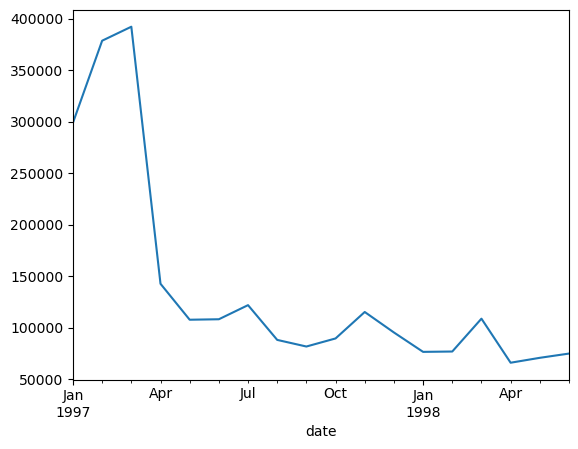

In [19]:
cdnow.reset_index().set_index('date')['price'].resample(rule = "MS").sum().plot()

#### Visualize all purchases within cohort

In [21]:
ids = cdnow['customer_id'].unique()
ids_selected = ids[0:10]

In [22]:
ids_selected

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10])

In [23]:
cdnow_cust_subset = cdnow[cdnow['customer_id'].isin(ids_selected)].groupby(['customer_id', 'date']).sum().reset_index()
cdnow_cust_subset

,customer_id,date,Unnamed: 0,quantity,price
0,1,1997-01-01,0,1,11.77
1,2,1997-01-12,3,6,89.00
2,3,1997-01-02,3,2,20.76
3,3,1997-03-30,4,2,20.76
4,3,1997-04-02,5,2,19.54
5,3,1997-11-15,6,5,57.45
6,3,1997-11-25,7,4,20.96
7,3,1998-05-28,8,1,16.99
8,4,1997-01-01,9,2,29.33
9,4,1997-01-18,10,2,29.73


/opt/anaconda3/lib/python3.11/site-packages/plotnine/geoms/geom_path.py:113: PlotnineWarning: geom_path: Each group consist of only one observation. Do you need to adjust the group aesthetic?
/opt/anaconda3/lib/python3.11/site-packages/plotnine/geoms/geom_path.py:113: PlotnineWarning: geom_path: Each group consist of only one observation. Do you need to adjust the group aesthetic?
/opt/anaconda3/lib/python3.11/site-packages/plotnine/geoms/geom_path.py:113: PlotnineWarning: geom_path: Each group consist of only one observation. Do you need to adjust the group aesthetic?


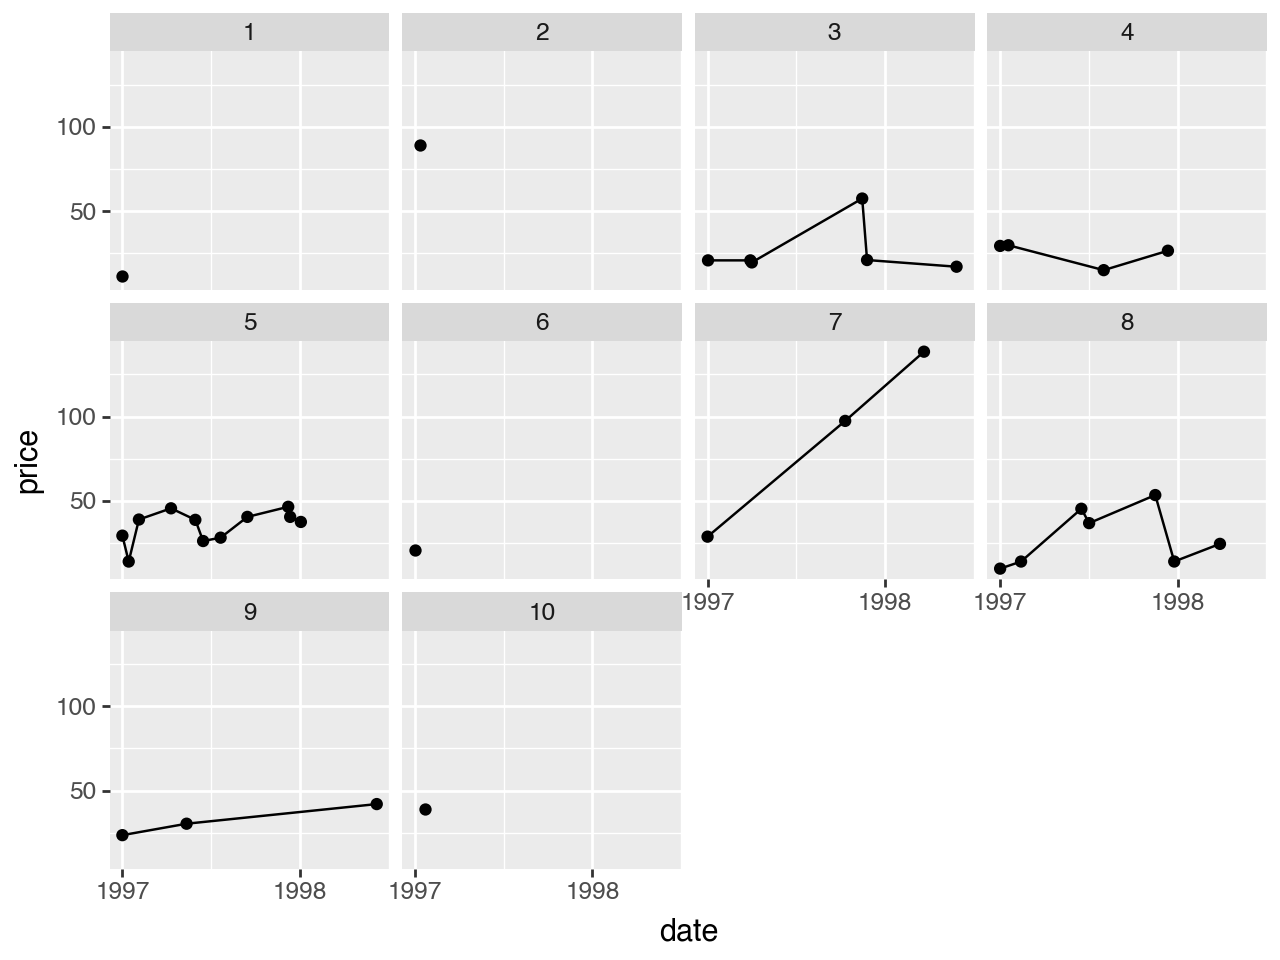

In [24]:
pn.ggplot(cdnow_cust_subset, aes(x = 'date', y = 'price', group = 'customer_id')) + pn.geom_line() + pn.geom_point()\
    + pn.facet_wrap('customer_id') + pn.scale_x_date(date_breaks = "1 year", date_labels = "%Y")

## Machine Learning

- How much will the customer spend in next 90 days? (Regression)
- What is the probability of customer spending in the next 90 days? (Classisfication)

#### Time Splitting Stage 

In [27]:
n_days = 90 
max_date = cdnow['date'].max()

cutoff = max_date - pd.to_timedelta(n_days, unit = "d")
cutoff

Timestamp('1998-04-01 00:00:00')

In [28]:
temporal_in_df = cdnow[cdnow['date'] <= cutoff] 
temporal_in_df

,Unnamed: 0,customer_id,date,quantity,price
0,0,1,1997-01-01,1,11.77
1,1,2,1997-01-12,1,12.00
2,2,2,1997-01-12,5,77.00
3,3,3,1997-01-02,2,20.76
4,4,3,1997-03-30,2,20.76
...,...,...,...,...,...
69654,69654,23568,1997-04-05,4,83.74
69655,69655,23568,1997-04-22,1,14.99
69656,69656,23569,1997-03-25,2,25.74
69657,69657,23570,1997-03-25,3,51.12


In [29]:
temporal_out_df = cdnow[cdnow['date'] > cutoff]
temporal_out_df

,Unnamed: 0,customer_id,date,quantity,price
8,8,3,1998-05-28,1,16.99
38,38,9,1998-06-08,2,41.98
68,68,25,1998-04-17,1,12.99
69,69,25,1998-05-25,1,10.49
70,70,25,1998-06-03,3,24.97
...,...,...,...,...,...
69583,69583,23534,1998-05-02,1,10.48
69623,69623,23555,1998-05-01,4,49.96
69624,69624,23555,1998-06-10,2,27.48
69631,69631,23556,1998-06-07,2,28.98


#### Feature Engineering (RFM)

Make targets from out data

In [31]:
target_df = temporal_out_df.drop(['Unnamed: 0','quantity', 'date'], axis = 1).groupby('customer_id').sum().rename({'price':'spend_90_total'}, axis = 1)\
            .assign(spend_90_flag = 1)
target_df

,spend_90_total,spend_90_flag
customer_id,,
3,16.99,1
9,41.98,1
25,73.43,1
29,48.45,1
31,117.99,1
...,...,...
23529,40.56,1
23534,10.48,1
23555,77.44,1


Recency (Date)

- Customer's recent purchase date

In [33]:
max_date = temporal_in_df['date'].max()
max_date

Timestamp('1998-04-01 00:00:00')

In [34]:
recency_df = temporal_in_df[['customer_id', 'date']].groupby('customer_id')\
                .apply(lambda x: (x['date'].max() - max_date) / pd.to_timedelta(1, "day")).to_frame().set_axis(["Recency"], axis = 1)
recency_df

/var/folders/4j/5_q1_j096m30w8450rgfrcph0000gn/T/ipykernel_16184/1288035169.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.


,Recency
customer_id,
1,-455.0
2,-444.0
3,-127.0
4,-110.0
5,-88.0
...,...
23566,-372.0
23567,-372.0
23568,-344.0


Frequency (Count)

- Number of Customer's purchases

In [36]:
frequency_df = temporal_in_df[['customer_id', 'date']].groupby('customer_id').count().set_axis(["Frequency"], axis = 1)
frequency_df

,Frequency
customer_id,
1,1
2,2
3,5
4,4
5,11
...,...
23566,1
23567,1
23568,3


Monetary (Price)

- Total Customer spending amount

In [38]:
monetary_df = temporal_in_df.groupby('customer_id')\
                .aggregate ({'price' : ["sum", "mean"]}).set_axis(["price_sum", "price_mean"], axis = 1)
monetary_df

,price_sum,price_mean
customer_id,,
1,11.77,11.770000
2,89.00,44.500000
3,139.47,27.894000
4,100.50,25.125000
5,385.61,35.055455
...,...,...
23566,36.00,36.000000
23567,20.97,20.970000
23568,121.70,40.566667


Combine all Features

In [40]:
features_df = pd.concat([recency_df, frequency_df, monetary_df], axis = 1)\
                .merge(target_df, left_index = True, right_index = True, how = "left").fillna(0)
features_df

,Recency,Frequency,price_sum,price_mean,spend_90_total,spend_90_flag
customer_id,,,,,,
1,-455.0,1,11.77,11.770000,0.00,0.0
2,-444.0,2,89.00,44.500000,0.00,0.0
3,-127.0,5,139.47,27.894000,16.99,1.0
4,-110.0,4,100.50,25.125000,0.00,0.0
5,-88.0,11,385.61,35.055455,0.00,0.0
...,...,...,...,...,...,...
23566,-372.0,1,36.00,36.000000,0.00,0.0
23567,-372.0,1,20.97,20.970000,0.00,0.0
23568,-344.0,3,121.70,40.566667,0.00,0.0


## Machine Learning

In [42]:
# Regressors

X = features_df[['Recency', 'Frequency', 'price_sum', 'price_mean']]

#### Next 90 Day Spend Prediction

- How Much Amount is the Customer Going to Spend in the next 90 Days

In [44]:
# Target Variable

y_spend = features_df['spend_90_total']

In [45]:
xgb_reg_spec= XGBRegressor(objective = "reg:squarederror", random_state = 123)

In [46]:
xgb_reg_model = GridSearchCV(estimator = xgb_reg_spec, param_grid = dict(learning_rate = [0.01, 0.1, 0.3, 0.5])\
                            ,scoring = 'neg_mean_absolute_error', refit = True, cv = 5)

In [47]:
xgb_reg_model.fit(X, y_spend)

GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, max_bin=None,
                                    max_cat_threshold=None,
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=123, ...),
             param_grid={'learning_rate': [0.01, 0.1, 0.3, 0.5]},
             scoring='neg_mean_absolute_error')

In [48]:
xgb_reg_model.best_score_

-10.939501193931802

In [49]:
xgb_reg_model.best_params_

{'learning_rate': 0.1}

In [50]:
xgb_reg_model.best_estimator_

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=123, ...)

In [51]:
prediction_reg = xgb_reg_model.predict(X)
prediction_reg

array([ 0.8516166,  2.0874057, 12.327984 , ...,  4.558194 ,  1.140923 ,
        3.5550523], dtype=float32)

#### Next 90 Day Spend Probability

- How Much is the Probability of a Customer Going to Spend in the next 90 Days

In [53]:
# Target Variable

y_prob = features_df['spend_90_flag']

In [54]:
xgb_clf_spec = XGBClassifier(objective = "binary:logistic", random_state = 123)

In [55]:
xgb_clf_model = GridSearchCV(estimator = xgb_clf_spec, param_grid = dict(learning_rate = [0.01, 0.1, 0.3, 0.5])\
                            ,scoring = 'roc_auc', refit = True, cv = 5)

In [56]:
xgb_clf_model.fit(X, y_prob)

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_bin=None,
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=123, ...),
             param_grid={'learning_rate': [0.01, 0.1, 0.3, 0.5]},
             scoring='roc_auc')

In [57]:
xgb_clf_model.best_score_

0.8344802222992829

In [58]:
xgb_clf_model.best_params_

{'learning_rate': 0.01}

In [59]:
xgb_clf_model.best_estimator_

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=123, ...)

In [60]:
prediction_clf = xgb_clf_model.predict_proba(X)
prediction_clf

array([[0.91622937, 0.08377061],
       [0.9173875 , 0.08261252],
       [0.7599223 , 0.24007767],
       ...,
       [0.86449254, 0.13550743],
       [0.9068537 , 0.09314632],
       [0.88331866, 0.11668134]], dtype=float32)

#### Feature Importance

1. Importance | Spend Prediction Model

In [62]:
spend_pred_importance = xgb_reg_model.best_estimator_.get_booster().get_score(importance_type = 'gain')

spend_pred_importance_df = pd.DataFrame(data = {'feature' : spend_pred_importance.keys(), 'value' : spend_pred_importance.values()})

spend_pred_importance_df['feature']= pd.Categorical(spend_pred_importance_df['feature']\
                                        ,categories=spend_pred_importance_df.sort_values('value', ascending=True)['feature']\
                                        ,ordered=True)
    
spend_pred_importance_df = spend_pred_importance_df.sort_values(by='value', ascending=False)
spend_pred_importance_df

,feature,value
2,price_sum,135610.156250
1,Frequency,73742.445312
3,price_mean,30542.488281
0,Recency,21092.818359


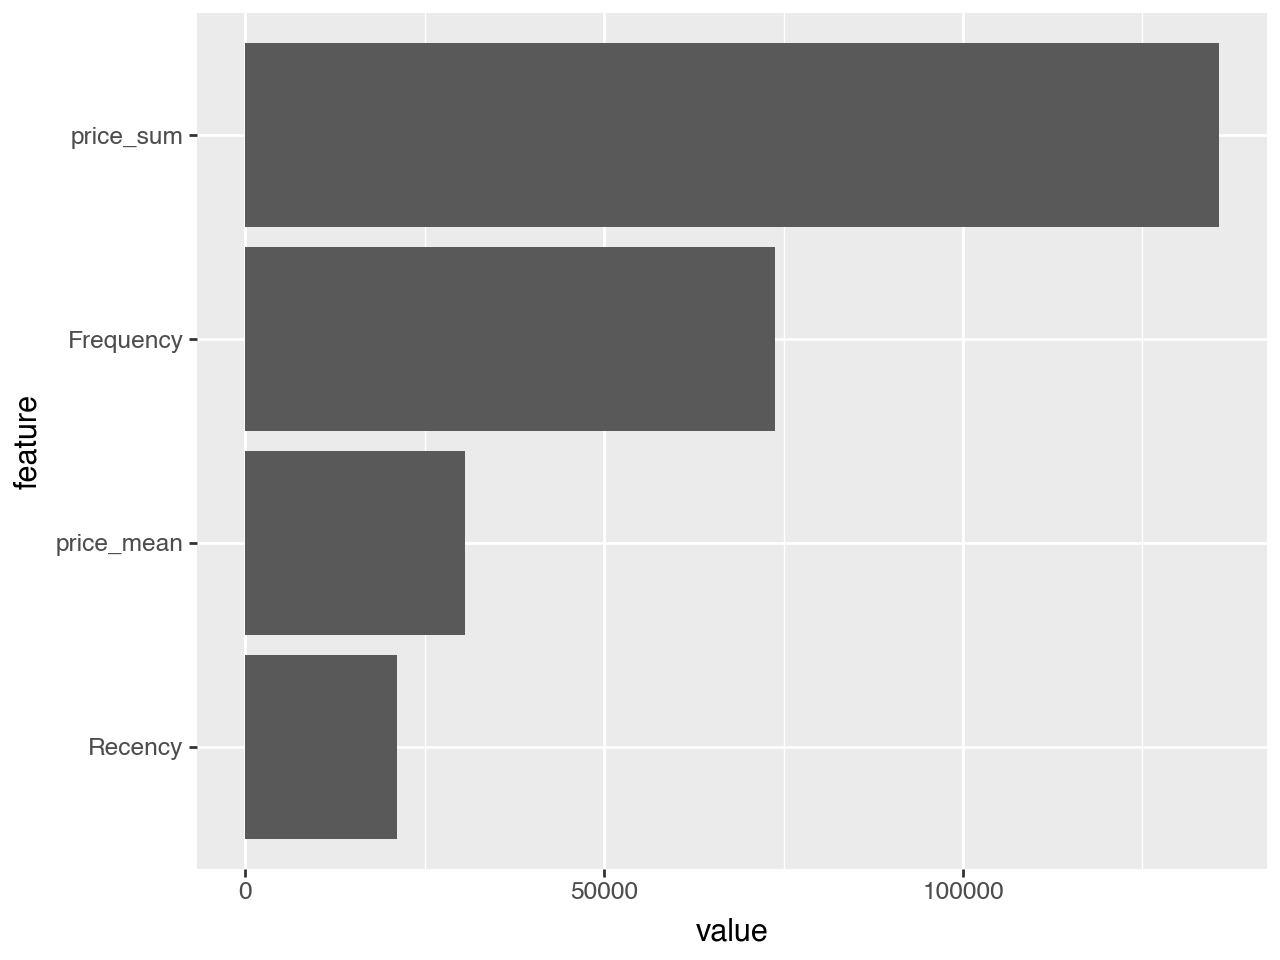

In [63]:
pn.ggplot(spend_pred_importance_df, aes(x = 'feature', y = 'value')) + pn.geom_col() + pn.coord_flip()

2. Importance | Spend Probablity Model

In [65]:
spend_prob_importance = xgb_clf_model.best_estimator_.get_booster().get_score(importance_type = 'gain')

spend_prob_importance_df = pd.DataFrame(data = {'feature' : spend_prob_importance.keys(), 'value' : spend_prob_importance.values()})

spend_prob_importance_df['feature']= pd.Categorical(spend_prob_importance_df['feature']\
                                        ,categories=spend_prob_importance_df.sort_values('value', ascending=True)['feature']\
                                        ,ordered=True)
spend_prob_importance_df = spend_prob_importance_df.sort_values(by='value', ascending=False)

spend_prob_importance_df

,feature,value
0,Recency,90.679802
1,Frequency,57.198505
3,price_mean,3.080837
2,price_sum,2.998964


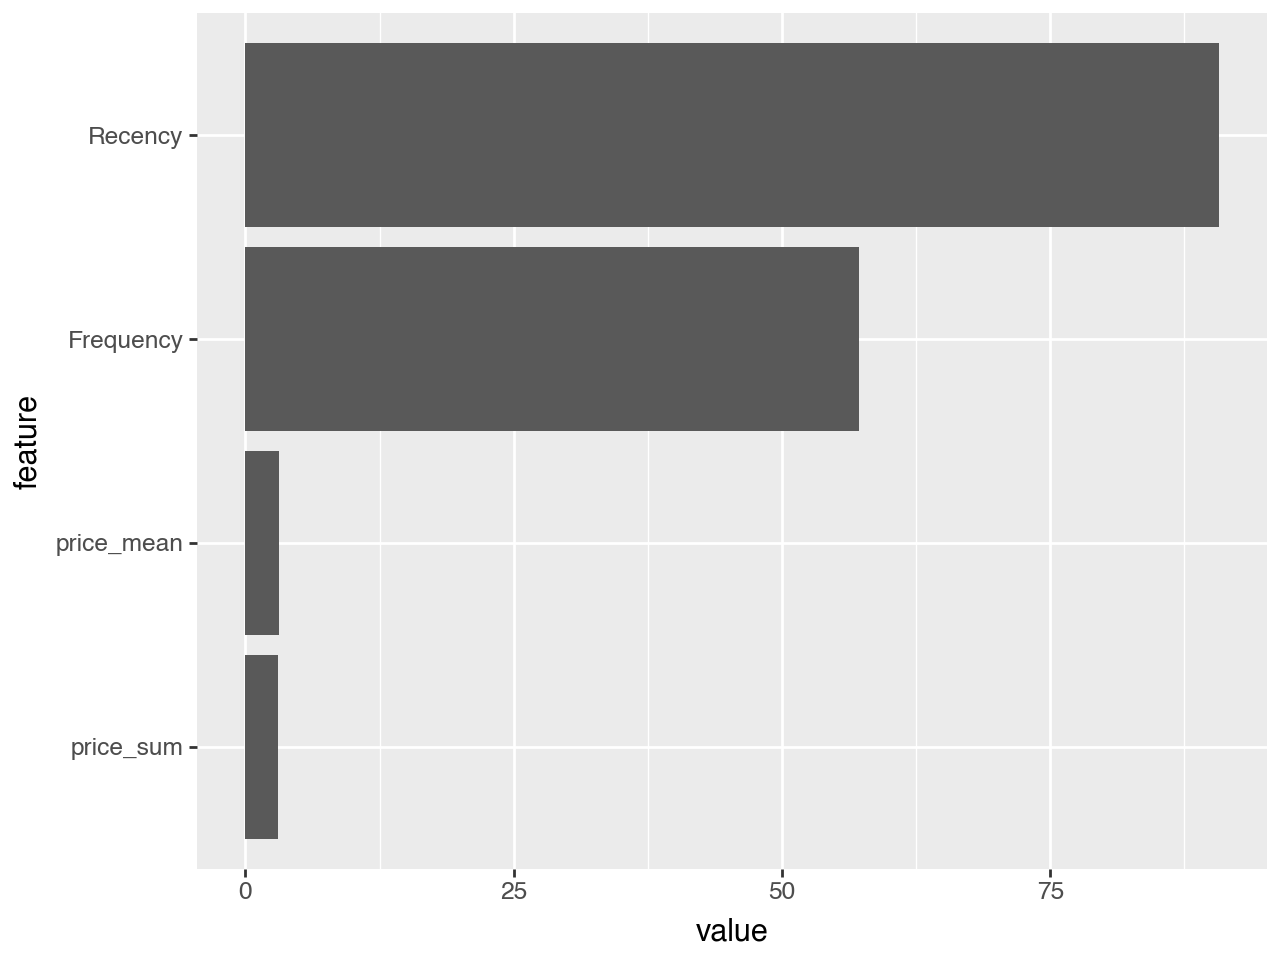

In [66]:
pn.ggplot(spend_prob_importance_df, aes(x = 'feature', y = 'value')) + pn.geom_col() + pn.coord_flip()

## Analysis

Predictions 

In [69]:
predictions_df = pd.concat([pd.DataFrame(prediction_reg).set_axis(['pred_spend'], axis = 1)\
                            , pd.DataFrame(prediction_clf)[[1]].set_axis(['pred_prob'], axis = 1)\
                                , features_df.reset_index()], axis = 1)

predictions_df

,pred_spend,pred_prob,customer_id,Recency,Frequency,price_sum,price_mean,spend_90_total,spend_90_flag
0,0.851617,0.083771,1,-455.0,1,11.77,11.770000,0.00,0.0
1,2.087406,0.082613,2,-444.0,2,89.00,44.500000,0.00,0.0
2,12.327984,0.240078,3,-127.0,5,139.47,27.894000,16.99,1.0
3,10.697600,0.237341,4,-110.0,4,100.50,25.125000,0.00,0.0
4,29.300179,0.450179,5,-88.0,11,385.61,35.055455,0.00,0.0
...,...,...,...,...,...,...,...,...,...
23565,1.215649,0.091442,23566,-372.0,1,36.00,36.000000,0.00,0.0
23566,1.105468,0.093146,23567,-372.0,1,20.97,20.970000,0.00,0.0
23567,4.558194,0.135507,23568,-344.0,3,121.70,40.566667,0.00,0.0
23568,1.140923,0.093146,23569,-372.0,1,25.74,25.740000,0.00,0.0


In [70]:
predictions_df.to_pickle('Customer Lifetime Value Project/CLV_CDnow/Files/predictions_df.pkl')

Importance

In [72]:
spend_pred_importance_df.to_pickle('Customer Lifetime Value Project/CLV_CDnow/Files/spend_pred_importance_df.pkl')
spend_prob_importance_df.to_pickle('Customer Lifetime Value Project/CLV_CDnow/Files/spend_prob_importance_df.pkl')

In [73]:
pd.read_pickle("Customer Lifetime Value Project/CLV_CDnow/Files/spend_pred_importance_df.pkl")

,feature,value
2,price_sum,135610.156250
1,Frequency,73742.445312
3,price_mean,30542.488281
0,Recency,21092.818359


Models

In [75]:
joblib.dump(xgb_reg_model, 'Customer Lifetime Value Project/CLV_CDnow/Files/xgb_reg_model.pkl')
joblib.dump(xgb_clf_model, 'Customer Lifetime Value Project/CLV_CDnow/Files/xgb_clf_model.pkl')

['Customer Lifetime Value Project/CLV_CDnow/Files/xgb_clf_model.pkl']

In [76]:
model = joblib.load('Customer Lifetime Value Project/CLV_CDnow/Files/xgb_clf_model.pkl')
model.predict_proba(X)

array([[0.91622937, 0.08377061],
       [0.9173875 , 0.08261252],
       [0.7599223 , 0.24007767],
       ...,
       [0.86449254, 0.13550743],
       [0.9068537 , 0.09314632],
       [0.88331866, 0.11668134]], dtype=float32)

In [144]:
import matplotlib.pyplot as plt
import seaborn as sns

In [198]:
clusters_df = features_df

In [200]:
from sklearn.preprocessing import StandardScaler

# Standardize the RFM values
scaler = StandardScaler()
clusters_scaled = scaler.fit_transform(clusters_df)

clusters_scaled

array([[-1.01200742, -0.42059144, -0.40830018, ..., -0.40355859,
        -0.31115841, -0.13513776],
       [-0.93848969, -0.1741687 , -0.03834136, ..., -0.40355859,
        -0.31115841, -0.13513776],
       [ 1.18015764,  0.5650995 ,  0.20342766, ...,  2.47795491,
        -1.36052222, -1.81509405],
       ...,
       [-0.27014668,  0.07225403,  0.11830312, ..., -0.40355859,
        -0.31115841, -0.13513776],
       [-0.45728272, -0.42059144, -0.34137898, ..., -0.40355859,
        -0.31115841, -0.13513776],
       [-0.45059929, -0.1741687 , -0.01400638, ..., -0.40355859,
        -0.31115841, -0.13513776]])

In [214]:
from sklearn.cluster import KMeans

# Apply K-means clustering
kmeans = KMeans(n_clusters=4, random_state=42)
kmeans.fit(clusters_scaled)

# Add the cluster labels to the RFM DataFrame
clusters_df['Clusters'] = kmeans.labels_

clusters_scaled

clusters_df.groupby('Clusters').mean()


,Recency,Frequency,price_sum,price_mean,spend_90_total,spend_90_flag,clusters_scaled
Clusters,,,,,,,
0,-137.666769,6.022748,223.276265,35.885728,56.286705,1.000000,0.031356
1,-397.958210,1.319206,36.192392,27.677491,0.000000,0.000000,1.000000
2,-128.754111,4.318209,173.093941,44.886474,0.000000,0.000000,2.999009
3,-23.411765,45.803922,2659.734510,74.717860,545.758627,0.941176,2.000000


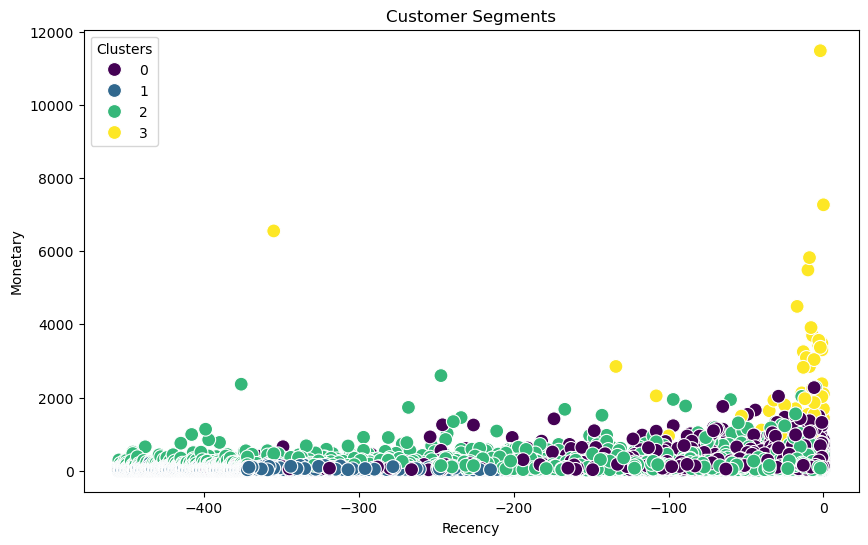

In [218]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Recency', y='price_sum', hue='Clusters', data=clusters_df, palette='viridis', s=100)
plt.title('Customer Segments')
plt.xlabel('Recency')
plt.ylabel('Monetary')
plt.show()

##### Analysis

1. Cluster 0:
- Customers have made purchases relatively recently and frequently.
- They have a moderate total and average spend.
- They have been active in the last 90 days.

2. Cluster 1:
- Customers have not made recent purchases and have a low frequency of purchases.
- Their total and average spend is low.
- They have not spent anything in the last 90 days.

3. Cluster 2:
- Customers have made purchases relatively recently and moderately frequently.
- They have a moderate total and average spend.
- They have not spent anything in the last 90 days.

4. Cluster 3:
- Customers have made purchases very recently and very frequently.
- They have the highest total and average spend.
- They have been very active in the last 90 days.

### Use Case 

##### 1. WHICH CUSTOMERS HAVE THE HIGHEST SPEND PROBABILITY IN THE NEXT 90 DAYS?
   - target for new products similar to what they have purchased in the past

In [80]:
predictions_df.sort_values('pred_prob', ascending = False)

,pred_spend,pred_prob,customer_id,Recency,Frequency,price_sum,price_mean,spend_90_total,spend_90_flag
12859,431.955383,0.643970,12860,-3.0,30,1389.08,46.302667,457.26,1.0
5476,83.370262,0.643970,5477,-2.0,23,684.21,29.748261,98.45,1.0
8034,317.018890,0.643970,8035,-3.0,42,1332.67,31.730238,376.24,1.0
15753,186.177826,0.643970,15754,-2.0,19,724.00,38.105263,471.72,1.0
498,929.121643,0.643970,499,-3.0,100,3427.55,34.275500,951.00,1.0
...,...,...,...,...,...,...,...,...,...
497,1.833620,0.082613,498,-431.0,2,120.13,60.065000,0.00,0.0
6315,0.464132,0.082613,6316,-427.0,2,205.90,102.950000,0.00,0.0
494,1.894441,0.082613,495,-451.0,2,72.07,36.035000,0.00,0.0
6365,2.096353,0.082613,6366,-431.0,2,92.69,46.345000,0.00,0.0


##### 2. WHICH CUSTOMERS HAVE RECENTLY PURCHASED, BUT UNLIKELY TO BUY?
   - Incentivize actions to increase probability
   - Provide discounts, Gamify(Rewards, Referral Bonus), Notifications

In [82]:
discount_cust_df = predictions_df[predictions_df['Recency'] > -90]
discount_cust_df.add(predictions_df[predictions_df['pred_prob'] > -0.20])
discount_cust_df.sort_values('pred_prob', ascending = False)

,pred_spend,pred_prob,customer_id,Recency,Frequency,price_sum,price_mean,spend_90_total,spend_90_flag
7591,2494.916016,0.643970,7592,-2.0,165,11478.02,69.563758,2512.91,1.0
709,295.962799,0.643970,710,-2.0,51,2216.45,43.459804,285.85,1.0
243,98.304939,0.643970,244,-3.0,20,1185.85,59.292500,101.56,1.0
7273,80.264366,0.643970,7274,-1.0,24,725.78,30.240833,49.48,1.0
3618,209.024139,0.643970,3619,-3.0,20,903.35,45.167500,136.44,1.0
...,...,...,...,...,...,...,...,...,...
21191,14.856362,0.133946,21192,-18.0,2,245.12,122.560000,0.00,0.0
6971,14.764078,0.133896,6972,-23.0,2,191.94,95.970000,0.00,0.0
16100,14.595891,0.133896,16101,-23.0,2,213.62,106.810000,0.00,0.0
15504,14.595891,0.133896,15505,-20.0,2,215.33,107.665000,0.00,0.0


##### 3. MISSED OPPORTUNITY---BIG SPENDERS TO LOOK OUT FOR!
   - Send bundle offers
   - Focus on missed opportunities

In [84]:
predictions_df[predictions_df['spend_90_total'] == 0.0].sort_values('pred_prob', ascending = False)

,pred_spend,pred_prob,customer_id,Recency,Frequency,price_sum,price_mean,spend_90_total,spend_90_flag
5054,113.941353,0.634723,5055,-8.0,20,797.11,39.855500,0.0,0.0
7322,85.233147,0.634723,7323,-10.0,22,827.28,37.603636,0.0,0.0
17522,117.985970,0.612479,17523,-5.0,17,2280.08,134.122353,0.0,0.0
22623,53.264175,0.611454,22624,-3.0,13,529.15,40.703846,0.0,0.0
10612,57.533554,0.611454,10613,-3.0,13,523.72,40.286154,0.0,0.0
...,...,...,...,...,...,...,...,...,...
5500,1.753985,0.082613,5501,-434.0,2,98.69,49.345000,0.0,0.0
54,2.172341,0.082613,55,-446.0,2,81.45,40.725000,0.0,0.0
462,1.894441,0.082613,463,-445.0,2,69.05,34.525000,0.0,0.0
459,2.440753,0.082613,460,-434.0,2,64.96,32.480000,0.0,0.0
